# Modèles de partitionnement de données <a class="tocSkip">
Dans cet exercice, nous allons explorer un jeu de données adapté sur les expéditions et les prix de produits de santé. Plus précisément, le jeu de données identifie les expéditions d'antirétroviraux (ARV) et de laboratoires VIH vers les pays soutenus. En outre, le jeu de données fournit les prix des produits et les dépenses associées de la chaîne logistique nécessaires pour acheminer les produits vers ces pays. Les données originales sont fournies par l'Agence américaine pour le développement international et peuvent être consultées sur [cette page](https://catalog.data.gov/dataset/supply-chain-shipment-pricing-data).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Chargement des données

Voici une description de nos données adaptées dans le fichier `Supply_Chain_Shipment_Pricing_Data.csv`:

| VARIABLE | DESCRIPTION | 
|:----|:----|
|id| identification number|
|project code|identification of the project|
|country|country to which the items are shipped|
|vendor|identification of the vendor of the item|
|manufacturing site|name of the manufacturer of the item|
|shipment mode|transportation mode (e.g., air, truck)|
|scheduled delivery date|programmed date for delivery|
|delivered to client date|real date of delivery|
|delivery recorded date|registered date of delivery|
|product group|main category of the item|
|product subgroup|subcategory of the item (e.g., HIV test, pediatric, Adult) |
|molecule type|description of the composition of the item (e.g., Nevirapine, HIV 1/2, Didanosine)|
|brand| item brand (e.g., generic or any other commercial brand)|
|dosage| specifications about the dosage of each item (e.g.,10mg/ml, 200mg)|
|dosage form|instructions for consumption (e.g., capsule, tablet, oral solution) |
|units per pack| number of units in each package|
|quantity pack sold| number of packages shipped to the specified country|
|value sold| total value in USD of the shipment (i.e., pack_price * quantity pack sold|
|pack price| price in USD per package|
|unit price| price in USD per unit|
|weight (kilograms)| total weight in kilograms of the shipment|
|freight cost (usd)| value in USD paid for transportation|
|insurance (usd)|value in USD paid for insurance|

Comme à la séance 5, nous allons importer les données. De plus, nous allons transformer les colonnes qui contiennent des dates et des valeurs numériques dans leur format correspondant. 

In [2]:
file = 'Supply_Chain_Shipment_Pricing_Data.csv'
df_SC = pd.read_csv(file)  # importation des données
print(df_SC.columns)

# Élimination des charactères spéciaux et remplacement des espaces
df_SC.columns = df_SC.columns.str.replace(' ', '_', regex=False)
df_SC.columns = df_SC.columns.str.replace('(', '', regex=False)
df_SC.columns = df_SC.columns.str.replace(')', '', regex=False)
df_SC.columns = df_SC.columns.str.replace('#', '', regex=False)
df_SC.columns = df_SC.columns.str.replace('/', '', regex=False)

# Transformation des types de données
df_SC['pq_first_sent_to_client_date'] = pd.to_datetime(df_SC['pq_first_sent_to_client_date'], errors='coerce')
df_SC['scheduled_delivery_date'] = pd.to_datetime(df_SC['scheduled_delivery_date'], errors='coerce')
df_SC['delivered_to_client_date'] = pd.to_datetime(df_SC['delivered_to_client_date'], errors='coerce')
df_SC['weight_kilograms'] = pd.to_numeric(df_SC['weight_kilograms'], errors='coerce')
df_SC['freight_cost_usd'] = pd.to_numeric(df_SC['freight_cost_usd'], errors='coerce')

df_SC.head()

Index(['id', 'project code', 'pq #', 'po / so #', 'asn/dn #', 'country',
       'managed by', 'fulfill via', 'vendor inco term', 'shipment mode',
       'pq first sent to client date', 'po sent to vendor date',
       'scheduled delivery date', 'delivered to client date',
       'delivery recorded date', 'product group', 'sub classification',
       'vendor', 'item description', 'molecule/test type', 'brand', 'dosage',
       'dosage form', 'unit of measure (per pack)', 'line item quantity',
       'line item value', 'pack price', 'unit price', 'manufacturing site',
       'first line designation', 'weight (kilograms)', 'freight cost (usd)',
       'line item insurance (usd)'],
      dtype='object')


,id,project_code,pq_,po__so_,asndn_,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,...,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,True,13.0,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",True,358.0,4521.50,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,True,171.0,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",True,1855.0,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",True,7590.0,45450.08,NaN


Pour cette analyse, nous choisirons également uniquement des données après 2010 et avec aucunes valeurs manquantes. Les seules données que nous utiliserons sont les colonnes `['country', 'line_item_value', 'weight_kilograms', 'freight_cost_usd']`.

In [3]:
df_SC.isna().sum()

id                                 0
project_code                       0
pq_                                0
po__so_                            0
asndn_                             0
country                            0
managed_by                         0
fulfill_via                        0
vendor_inco_term                   0
shipment_mode                    360
pq_first_sent_to_client_date    2681
po_sent_to_vendor_date             0
scheduled_delivery_date            0
delivered_to_client_date           0
delivery_recorded_date             0
product_group                      0
sub_classification                 0
vendor                             0
item_description                   0
moleculetest_type                  0
brand                              0
dosage                          1736
dosage_form                        0
unit_of_measure_per_pack           0
line_item_quantity                 0
line_item_value                    0
pack_price                         0
u

In [4]:
# conserver seulement les données après 2010
mask = df_SC['delivered_to_client_date'] >= '2010-01-01'
df_SC = df_SC[mask]

# conserver seulement les colonnes intéressantes
selected_columns = ['country', 'line_item_value', 'weight_kilograms', 'freight_cost_usd']
df_SC = df_SC[selected_columns]

# conserver seulement les lignes sans valeurs manquantes
df_SC = df_SC.dropna()
df_SC.head()

,country,line_item_value,weight_kilograms,freight_cost_usd
18,Vietnam,3465.00,34.0,807.47
1425,Mozambique,5721.60,205.0,1380.45
1426,Nigeria,58.75,1.0,19480.97
1609,Tanzania,136573.92,640.0,2751.00
2068,Ethiopia,74066.00,2031.0,6774.59


Puisque l'analyse de clustering sera effectuée au niveau du pays, nous utilisons la méthode `groupby` pour préparer les données. La méthode `DataFrame.groupby(...).agg(...)` nous permet d'agréger chaque colonne différemment en fonction de ce qui est spécifié dans le dictionnaire. Pour plus d'information, vous pouvez consulter les liens suivants: [lien1](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.core.groupby.DataFrameGroupBy.agg.html) et [lien2](https://pbpython.com/groupby-agg.html).

In [5]:
df_SC_selected = df_SC.groupby(['country']).agg({'line_item_value': 'sum',
                                                 'weight_kilograms': 'mean',
                                                 'freight_cost_usd': 'mean'})
df_SC_selected

,line_item_value,weight_kilograms,freight_cost_usd
country,,,
Afghanistan,1.736000e+03,44.500000,540.525000
Angola,1.816000e+05,362.200000,6166.414000
Benin,5.454805e+05,2323.600000,11638.258000
Botswana,1.303711e+06,525.766667,3451.025333
Burundi,2.277174e+06,512.750000,5572.184286
Cameroon,1.234366e+07,3977.666667,33026.949815
"Congo, DRC",2.777920e+06,592.355769,6721.951058
Côte d'Ivoire,6.147014e+07,2699.873118,10091.968387
Dominican Republic,1.558134e+06,824.892857,8780.877857


Puisque les algorithmes de clustering sont typiquement fortement influencés par l'échelle (c.-à-d., qu'ils ne sont pas invariants à l'échelle), une pratique courante est de mettre à l'échelle les données avant de les utiliser. Nous optons pour la standardisation `z-score`. Nous conservons également la liste des noms de colonnes contenant les valeurs initiales et les valeurs standardisées afin de faciliter la tâche lors d'une référence.

In [6]:
for col in df_SC_selected.columns:
    df_SC_selected['z_'+col] = (df_SC_selected[col] - df_SC_selected[col].mean()) / df_SC_selected[col].std()

normal_columns = list(df_SC_selected.columns[:3])
z_columns = list(df_SC_selected.columns[3:])

df_SC_selected

,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd
country,,,,,,
Afghanistan,1.736000e+03,44.500000,540.525000,-0.561087,-0.957089,-1.250062
Angola,1.816000e+05,362.200000,6166.414000,-0.557071,-0.808194,-0.499511
Benin,5.454805e+05,2323.600000,11638.258000,-0.548946,0.111043,0.230490
Botswana,1.303711e+06,525.766667,3451.025333,-0.532016,-0.731536,-0.861771
Burundi,2.277174e+06,512.750000,5572.184286,-0.510279,-0.737637,-0.578787
Cameroon,1.234366e+07,3977.666667,33026.949815,-0.285504,0.886244,3.083962
"Congo, DRC",2.777920e+06,592.355769,6721.951058,-0.499098,-0.700328,-0.425396
Côte d'Ivoire,6.147014e+07,2699.873118,10091.968387,0.811442,0.287388,0.024199
Dominican Republic,1.558134e+06,824.892857,8780.877857,-0.526335,-0.591347,-0.150714


Maintenant, nous pouvons explorer les données en utilisant le diagramme par paire dans seaborn.  

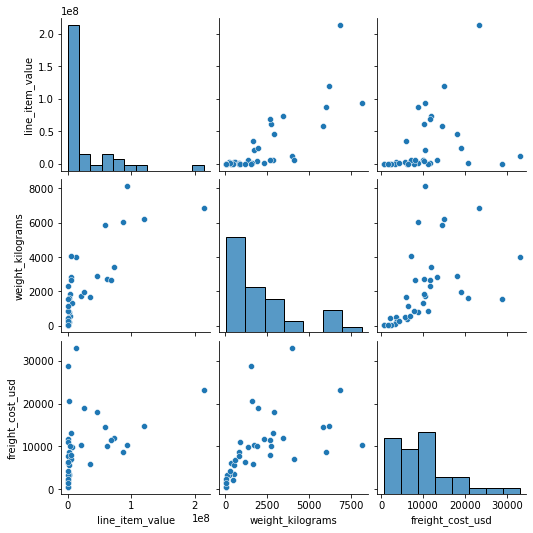

In [7]:
sns.pairplot(data=df_SC_selected[normal_columns], palette = 'deep')

# Modèle 1: k-means

Nous appliquons d'abord l'algorithme de clustering k-means en utilisant la librairie *scikit-learn*. La classe `sklearn.cluster.KMeans(...)` retourne un objet qui donne plusieurs résultats (lien fourni ci-dessous). La sortie principale est `.labels_` (notez que c'est un nom d'attribut) qui retourne la liste contenant l'étiquette de groupe de toutes les données. Afin d'apprendre les étiquettes à partir des données, nous devons préalablement appeler `.fit(X)` pour passer les variables d'entrée `X` (nos variables normalisées par le z-score) à la méthode.

[Lien vers la description](https://scikit-learn.org/stable/modules/clustering.html#k-means) et [lien vers la classe KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

In [8]:
# sélectionnons les données que nous voulons utiliser
X = df_SC_selected[z_columns]

# initialisons une objet k-means avec 3 groupes et entraînons le sur les données
# étant donné qu'il y a une part d'aléatoire dans l'algorithme, nous fixons aussi
# `random_state=0` pour s'assurer de toujours avoir le même résultat
kmeans_object = KMeans(n_clusters=3, random_state=0)
kmeans_object.fit(X)

# nous obtenons maintenant la liste des étiquettes de groupes et l'ajoutons au DataFrame
# il se peut que les numéros de groupe change au fil du temps, mais les groupes demeureront les même
df_SC_selected['K3_cluster'] = kmeans_object.labels_
df_SC_selected.head()

,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd,K3_cluster
country,,,,,,,
Afghanistan,1736.00,44.500000,540.525000,-0.561087,-0.957089,-1.250062,1
Angola,181600.00,362.200000,6166.414000,-0.557071,-0.808194,-0.499511,1
Benin,545480.52,2323.600000,11638.258000,-0.548946,0.111043,0.230490,1
Botswana,1303710.71,525.766667,3451.025333,-0.532016,-0.731536,-0.861771,1
Burundi,2277173.52,512.750000,5572.184286,-0.510279,-0.737637,-0.578787,1


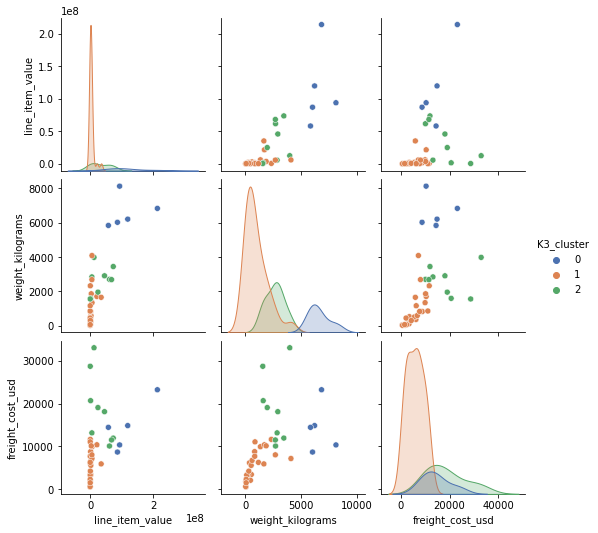

In [9]:
sns.pairplot(data=df_SC_selected[normal_columns+["K3_cluster"]], hue='K3_cluster', palette='deep')

Afin de choisir le nombre optimal de groupes (dans le cas où il n'est pas prédéfini), nous pouvons comparer les résultats de différents nombres de groupes basés sur:

* l'**inertie** ou la somme des carrés (SSE) au sein des groupes : Celle-ci mesure la compacité de chaque groupe. Il s'agit de la fonction objective que l'algorithme standard k-means optimise (voir [lien](https://scikit-learn.org/stable/modules/clustering.html)). Elle peut être obtenue par l'attribut `.inertia_` de l'objet k-means. 
* la valeur **silhouette** : Celle-ci représente la façon dont les clusters sont séparés les uns des autres (voir [lien](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)). Cela peut être fait avec la fonction `sklearn.metrics.silhouette_score(X, cluster_labels)`.

En pratique, un nombre plus petit de groupes est généralement préféré. Nous choisissons donc le nombre de groupes où des améliorations significatives sont observées dans les deux mesures parmi des choix raisonnables de $k$.

<AxesSubplot:>

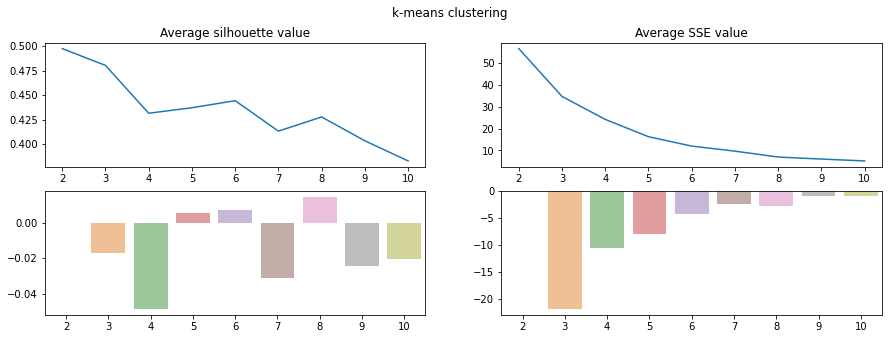

In [10]:
# nombre de groupes à explorer
kmeans_range = list(range(2,11))

# listes vides pour enregistrer les résultats
inertia_list = []
silhouette_list = []

for k in kmeans_range:
    # entraîner l'algorithme
    kmeans_object = KMeans(n_clusters=k, random_state=0).fit(X)

    # enregistrer l'inertie
    inertia_list.append(kmeans_object.inertia_)

    # calculer la valeur de la silhouette et l'enregistrer
    silhouette_val = silhouette_score(X, kmeans_object.labels_)
    silhouette_list.append(silhouette_val)

# calculer la différence marginale de l'inertie pour chaque valeur de k
diff_inertia = [inertia_list[i] - inertia_list[max(0,i-1)] for i in range(len(kmeans_range))]
# calculer la différence marginale de la silhouette pour chaque valeur de k
diff_silhouette = [silhouette_list[i] - silhouette_list[max(0,i-1)] for i in range(len(kmeans_range))]

# tracer les résultats avec une grille de 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('k-means clustering')

sns.lineplot(ax=axes[0,0], x=kmeans_range, y=silhouette_list).set_title('Average silhouette value')
sns.lineplot(ax=axes[0,1], x=kmeans_range, y=inertia_list).set_title('Average SSE value')
sns.barplot(ax=axes[1,0], x=kmeans_range, y=diff_silhouette, alpha=0.5)
sns.barplot(ax=axes[1,1], x=kmeans_range, y=diff_inertia, alpha=0.5)

# Modèle 2: clustering agglomérant

Dans certains cas, nous devons créer une hiérarchie de groupes plutôt qu'un seul niveau de groupes pour permettre différents niveaux d'agrégation et de désagrégation (par exemple, hiérarchie produit/client). L'une des méthodes couramment utilisées est le clustering agglomérant, qui peut être utilisé pour assurer la cohérence hiérarchique des groupes. Vous trouverez plus de détails sur [lien vers la description](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) et [lien vers la fonction](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

Ici, nous allons démontrer le concept en montrant les résultats basés sur le nombre de groupes $k=2, 3, 4$. La version par défaut de cette méthode optimise la somme des carrés à l'intérieur des clusters, ce qui est le même objectif que dans le k-means standard (mais d'autres objectifs sont disponibles, comme décrit dans le lien).

In [11]:
# 2 groupes
hcluster2 = AgglomerativeClustering(n_clusters=2).fit(X)
df_SC_selected['A2_cluster'] = hcluster2.labels_
# afficher le nombre de pays sous chaque groupe
print(df_SC_selected['A2_cluster'].value_counts())

# 3 groupes
hcluster3 = AgglomerativeClustering(n_clusters=3).fit(X)
df_SC_selected['A3_cluster'] = hcluster3.labels_
print(df_SC_selected['A3_cluster'].value_counts())

# 4 groupes
hcluster4 = AgglomerativeClustering(n_clusters=4).fit(X)
df_SC_selected['A4_cluster'] = hcluster4.labels_
print(df_SC_selected['A4_cluster'].value_counts())

df_SC_selected.tail(10)

0    33
1     5
Name: A2_cluster, dtype: int64
2    17
0    16
1     5
Name: A3_cluster, dtype: int64
2    17
1    11
3     5
0     5
Name: A4_cluster, dtype: int64


,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd,K3_cluster,A2_cluster,A3_cluster,A4_cluster
country,,,,,,,,,,
South Africa,8.685259e+07,6020.439716,8683.827624,1.378208,1.843617,-0.163662,0,1,1,0
South Sudan,6.998661e+05,300.915254,4234.216271,-0.545499,-0.836916,-0.757286,1,0,2,2
Sudan,2.293064e+05,63.714286,1507.975476,-0.556006,-0.948083,-1.120994,1,0,2,2
Swaziland,5.618971e+06,2683.739130,8030.255652,-0.435660,0.279827,-0.250855,1,0,0,1
Tanzania,7.349008e+07,3444.231788,11947.480662,1.079836,0.636242,0.271743,2,0,0,1
Togo,1.532580e+05,1162.500000,6272.360000,-0.557704,-0.433123,-0.485376,1,0,2,2
Uganda,6.803387e+07,2682.802273,11508.059523,0.958004,0.279388,0.213120,2,0,0,1
Vietnam,3.503135e+07,1652.715190,5915.752468,0.221090,-0.203377,-0.532951,1,0,2,2
Zambia,1.195445e+08,6204.486755,14856.484636,2.108185,1.929873,0.659834,0,1,1,0


Nous affichons maintenant les groupes.

Text(0.5, 1.0, 'A4_cluster')

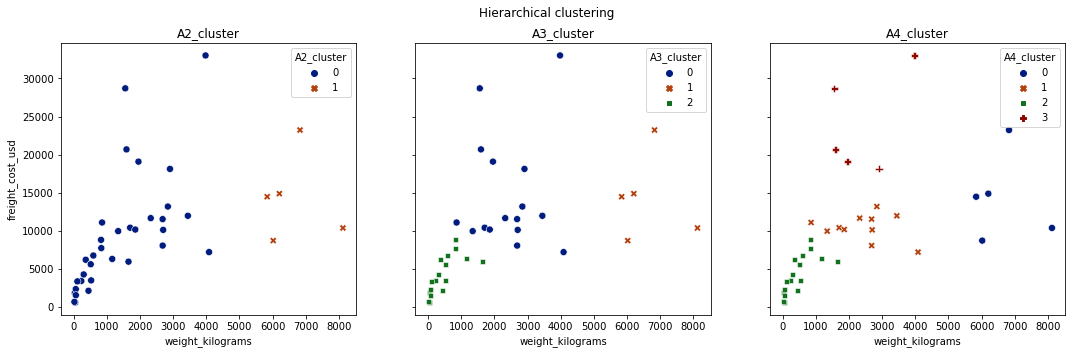

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5),sharey=True)
fig.suptitle('Hierarchical clustering')

# 2 groupes
sns.scatterplot(data = df_SC_selected, ax=axes[0], x=normal_columns[1], y=normal_columns[2],
                hue='A2_cluster', style='A2_cluster', palette='dark', s=50)
axes[0].set_title('A2_cluster')

# 3 groupes
sns.scatterplot(data = df_SC_selected, ax=axes[1], x=normal_columns[1], y=normal_columns[2],
                hue='A3_cluster', style='A3_cluster', palette='dark', s=50)
axes[1].set_title('A3_cluster')

# 4 groupes
sns.scatterplot(data = df_SC_selected, ax=axes[2], x=normal_columns[1], y=normal_columns[2],
                hue='A4_cluster', style='A4_cluster', palette='dark', s=50)
axes[2].set_title('A4_cluster')